# Emotion Classification

![](https://3ccontactservices.com/wp-content/uploads/2017/11/customer-experience-measurement-1024x757.jpg)

### Contents
1. Abstract
2. Dataset
3. Goal
4. Importing required libraries and dataset
5. Data Exploration
6. Creating the Baseline
7. Text Tokenizer Comparison
8. Data Preprocessing
9. Deploying Models
    - KNN Classifier
    - Linear Support Vector Machine Classifier
    - Random Forest Classifier
10. Error Analysis
11. Hyper Parameter Tweaking
12. Model Comparison
13. Conclusion

*********************************
### Abstract
The classification of emotion varies according to the researchers, the general basic emotion found in most research studies includes happy, sad, anger, fear, disgust, surprise, where these emotions were based on a two-dimensional plane commonly called the valence-arousal plane. Positive emotions can be categorized as happiness or surprise, while negative emotions can be associated with sadness, anger, fear, and disgust. Emotional stress may be influenced by negative experiences over a long and continuous period. Emotion classification can be divided into two classes, primary emotion such as joy, sadness, anger, fear disgust, and surprise, and secondary emotion, which evokes a mental image that correlates to memory or primary emotion.

### Dataset
The dataset which is used here, is collected from Kaggle website. Here is the link of the dataset : https://www.kaggle.com/anjaneyatripathi/emotion-classification-nlp?select=emotion-labels-train.csv.

### Goal
The goal of this project is to create a model which will classify different emotions based on the text provided in the dataset.
*********************

### Importing required libraries and Dataset

In [1]:
from pprint import pprint
!pip install emoji

# Setup
import os
import re
import time

import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import sklearn
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.validation import check_is_fitted

%matplotlib inline
sns.set_style('white')
sns.set_context('notebook')

random_state = 143

### Understanding the Dataset and creating the problem statements!
From the information in several texts to determine the **emotion** that each of these convey.

* How will your solution be used?
It will be used to categorise other tweets and other trending information regarding a specific
topic to determine the emotion behind.

* What are the current solutions/workarounds (if any)?
Current solutions use natural language processing by creating, or using readily available, embeddings
of the words. These embeddings are vectors that represent several *dimensions* of the word and allow them
to be compared with each other. Words with similar embeddings tend to have a similar meaning or used
in similar contexts. (Similar work)

* How should you frame this problem (supervised/unsupervised, online/offline, etc.)
Data is classified, so a supervised algorithm might be better suited. Embeddings can be tested using
words within the data or using other databases in english.

* How should performance be measured?
Performance is measured in accuracy, though ideally it should be able to output the probability of it
being from several classes (e.g. happy and angry).

***********************************

### Data loading

In [2]:
def load_emotion_data(dataset):
    """
    Loads the required dataset from the emotions input
    :param dataset:
    :return:
    """
    base_path = '../input/emotion-classification-nlp/'
    dataset_name = 'emotion-labels-%s.csv' % dataset

    data = pd.read_csv(os.path.join(base_path, dataset_name))
    return data['text'].values, data['label'].values

train_X, train_y = load_emotion_data('train')
val_X, val_y = load_emotion_data('val')
test_X, test_y = load_emotion_data('test')



print(train_X)

['Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious'
 "Oh dear an evening of absolute hilarity I don't think I have laughed so much in a long time! 😂"
 'Been waiting all week for this game ❤️❤️❤️ #cheer #friday ❤️' ...
 "@SilkInSide @TommyJoeRatliff that's so pretty! I love the sky in the background and the purple highlights with the dull colors is great"
 '@BluesfestByron second artist announcement looking good #bluesfest2017 #blues #Music #byronbay'
 'I can literally eat creamy pesto pasta topped with grilled chicken, sun dried tomatoes, asparagus and pine nuts every single day of my life']


***************
### Data Exploration

Columns in the text

| Column name | Description |
|-|-|
| text | Piece of text |
| label | Assigned emotion to the text |


***********************

**Adding Labels to the dataset**

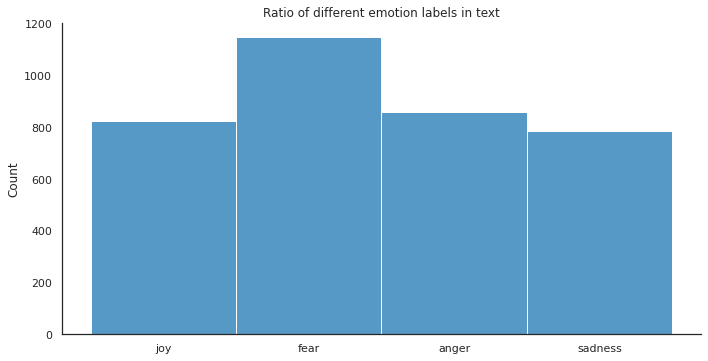

In [3]:
# Labels
sns.displot(train_y, height=5, aspect=2)
plt.title('Ratio of different emotion labels in text')
plt.show()


### Adding the Vectorizer Model to the Dataset
Vectorization is a technique by which you can make your code execute fast. It is a very interesting and important way to optimize algorithms when you are implementing it from scratch.

Now, with the help of highly optimized numerical linear algebra libraries in C/C++, Octave/Matlab, Python, …etc. We can make our code run efficiently.

     word  count  length
0    just   4798       4
1     got   3769       3
2    back    842       4
3    from   3488       4
4  seeing   7917       6


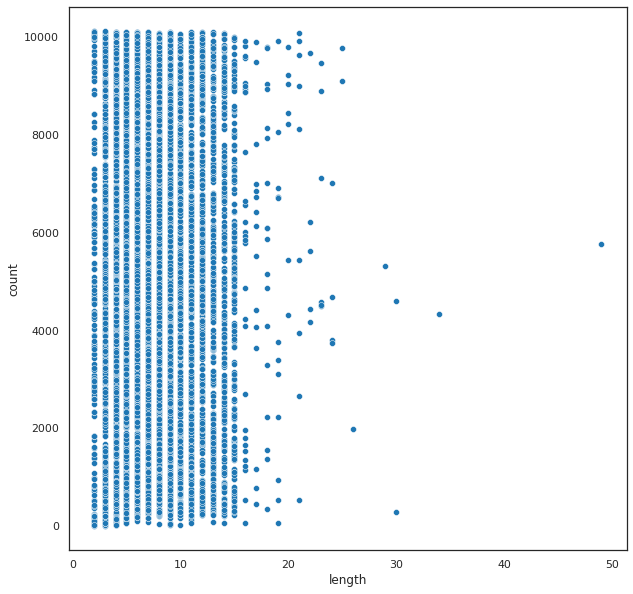

In [4]:
vectorizer = CountVectorizer()
vectorizer.fit(train_X)

vocabulary = pd.DataFrame(vectorizer.vocabulary_.items(), columns=['word', 'count'])
vocabulary['length'] = vocabulary.apply(lambda x: len(x[0]), axis=1)


print(vocabulary.head())

plt.figure(figsize=(10, 10))
sns.scatterplot(data=vocabulary, x='length', y='count')
plt.show()

### Baseline
A baseline is a simple model that provides reasonable results on a task and does not require much expertise and time to build. Common baseline models include linear regression when predicting continuous values, logistic regression when classifying structured data, pretrained convolutional neural networks for vision related tasks, and recurrent neural networks and gradient boosted trees for sequence modeling (Ameisen 2018).

Do a simple ML approach to see how much accuracy we can get.

For the machine learning baseline framework, what are the models that are going to be used here,

* **KNN Classifier** : K nearest neighbors is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions). KNN has been used in statistical estimation and pattern recognition already in the beginning of 1970's as a non-parametric technique.


* **Random Forest Classifier** : Random forest is a flexible, easy to use machine learning algorithm that produces, even without hyper-parameter tuning, a great result most of the time. It is also one of the most used algorithms, because of its simplicity and diversity (it can be used for both classification and regression tasks). In this post we'll learn how the random forest algorithm works, how it differs from other algorithms and how to use it.



* **Linear Support Vector Classifier** : The objective of a Linear SVC (Support Vector Classifier) is to fit to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data. From there, after getting the hyperplane, you can then feed some features to your classifier to see what the "predicted" class is.

Let's deploy the models and create the baseline for this project

Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious
  (0, 4798)	1
  (0, 3769)	1
  (0, 842)	1
  (0, 3488)	2
  (0, 7917)	1
  (0, 3593)	1
  (0, 4383)	1
  (0, 1434)	1
  (0, 507)	1
  (0, 3093)	1
  (0, 8504)	1
  (0, 4271)	1
  (0, 5051)	1
  (0, 8264)	1
  (0, 5921)	1
  (0, 4114)	1
Using classifier: KNeighborsClassifier()
	time: 0.6948873996734619
	scores: [0.36791148 0.3582296  0.41493776 0.39196676 0.36426593]
	best: 0.4149377593360996
	average: 0.37946230503097667
Using classifier: LinearSVC(max_iter=10000, random_state=143)
	time: 1.8159236907958984
	scores: [0.83679115 0.85477178 0.85338866 0.8365651  0.79916898]
	best: 0.8547717842323651
	average: 0.836137132523381
Using classifier: RandomForestClassifier(n_jobs=8, random_state=143)
	time: 14.152443647384644
	scores: [0.82572614 0.85338866 0.82849239 0.81855956 0.77146814]
	best: 0.8533886583679114
	average: 0.8195269786171039
Fitting best classifier


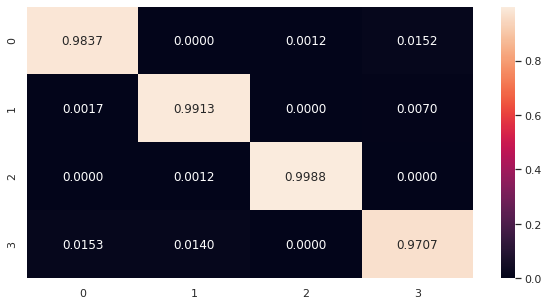

Best classifier is: LinearSVC(max_iter=10000, random_state=143) 0.836137132523381


In [5]:
def test_classifiers(classifiers, X, y, output=True):
    best_classifier = None
    best_score = 0
    for _clf in classifiers:
        try:
            clf = sklearn.clone(_clf)
            start = time.time()
            scores = cross_val_score(clf, X, y)

            if output:
                print('Using classifier:', clf)
                print('\ttime:', time.time() - start)
                print('\tscores:', scores)
                print('\tbest:', np.max(scores))
                print('\taverage:', np.average(scores))

            max_score = np.average(scores)
            if max_score > best_score:
                best_score = max_score
                best_classifier = clf
        except Exception as e:
            print('** FAILED ** classifier', _clf)
            print(e)

    print('Fitting best classifier')
    best_classifier.fit(X, y)
    y_pred = best_classifier.predict(X)

    conf_matrix = confusion_matrix(y, y_pred, normalize='true')

    plt.figure(figsize=(10, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='.4f')
    plt.show()

    return best_classifier, best_score


classifiers = [
    KNeighborsClassifier(),
    LinearSVC(max_iter=10000, random_state=random_state),
    RandomForestClassifier(random_state=random_state, n_jobs=8),
    # MLPClassifier(random_state=random_state), # Takes a long time
]
prep_pipeline = Pipeline([
    ('vectorizer', CountVectorizer())
])

train_X_transformed = prep_pipeline.fit_transform(train_X)
print(train_X[0])
print(train_X_transformed[0])

best_clf, best_score = test_classifiers(classifiers, train_X_transformed, train_y)
print('Best classifier is:', best_clf, best_score)

### Baseline Model Comparison
We have deployed three machine learning models and created the baseline structure. Now lets check the accuracy of the models.

|Model|Accuracy Score|
|---|---|
|KNN Classifier|0.38|
|Random Forest Clasifier|0.82|
|Linear SVC|0.84|

Best Classifier Model here, **Linear Support Vector Classifier**, *with accuracy score of 0.84*.

*********************************
### Text tokenizer comparison

The CountTokenizer creates vector per phrase with n columns, where n is the amount of different words
found in the text corpus. On the other hand, Keras Tokenizer converts each sentence to the numbers that
represent the word in the dictionary, maintaining the order of the words.

[[   0    0    0 ...   19  116  188]
 [   0    0    0 ...  209   59  309]
 [   0    0    0 ...  365  773  839]
 ...
 [   0    0    0 ... 1251    8  149]
 [   0    0    0 ...  251  449 4886]
 [   0    0    0 ...    7   11  100]]
Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious
[21, 90, 95, 39, 569, 2546, 10, 2547, 107, 183, 75, 1221, 39, 526, 19, 116, 188]
Using classifier: KNeighborsClassifier()
	time: 0.5975832939147949
	scores: [0.30428769 0.34854772 0.39695712 0.34626039 0.29362881]
	best: 0.3969571230982019
	average: 0.33793634555924645


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Using classifier: LinearSVC(max_iter=10000, random_state=143)
	time: 43.83446645736694
	scores: [0.23651452 0.23651452 0.27524205 0.2700831  0.23545706]
	best: 0.2752420470262794
	average: 0.2507622517748838
Using classifier: RandomForestClassifier(n_jobs=8, random_state=143)
	time: 4.394486427307129
	scores: [0.51175657 0.85892116 0.88520055 0.86565097 0.58310249]
	best: 0.8852005532503457
	average: 0.7409263495055612
Fitting best classifier


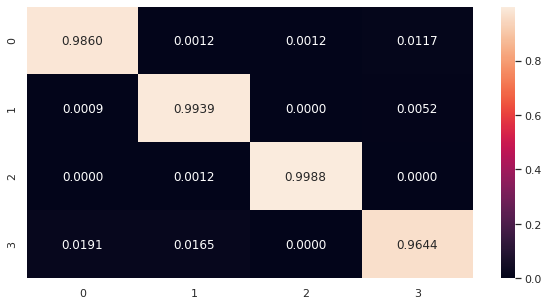

Best classifier is: RandomForestClassifier(n_jobs=8, random_state=143) 0.7409263495055612


In [6]:
# Test using Keras tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_X)

train_X_transformed = tokenizer.texts_to_sequences(train_X)
train_X_padded = pad_sequences(train_X_transformed)
print(train_X_padded)

print(train_X[0])
print(train_X_transformed[0])

best_clf, best_score = test_classifiers(classifiers, train_X_padded, train_y)
print('Best classifier is:', best_clf, best_score)

### Text Tokenizer Model Comparison
We have deployed three machine learning models and created the Text Tokenizer structure. Now lets check the accuracy of the models.

|Model|Accuracy Score|
|---|---|
|KNN Classifier|0.34|
|Random Forest Clasifier|0.74|
|Linear SVC|0.25|

Best Classifier Model here, **Random Forest Classifier**, *with accuracy score of 0.74*.

******************************

### Data Preprocessing

While it didn't give better results, it would be interesting to check with other classifiers
or go directly with an RNN. Before that I'll be trying several preprocessing techniques
to see if filtering the text might help. Among these are:
- Removing handles (@name) as I don't want the algorithm to associate a person with sentiment.
- Remove coded values (e.g. &amp;).
- Convert emojis to tokens (as those are good representation of sentiment yet are filtered by the
tokenizers).
- Review if there is other extraneous input like URL's or other
*********************************
### 1. Remove handles

In [7]:
class RemoveHandles(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        values = pd.Series(X)
        return values.replace(r'@\w+', '', regex=True).values

remove_handles = RemoveHandles()
print(remove_handles.fit_transform(train_X[:10]))

['Just got back from seeing  in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious'
 "Oh dear an evening of absolute hilarity I don't think I have laughed so much in a long time! 😂"
 'Been waiting all week for this game ❤️❤️❤️ #cheer #friday ❤️'
 " : Thank you so much, Gloria! You're so sweet, and thoughtful! You just made my day more joyful! I love you too! 😊💕"
 'I feel so blessed to work with the family that I nanny for ❤️ nothing but love &amp; appreciation, makes me smile.'
 'Today I reached 1000 subscribers on YT!! , #goodday, #thankful'
 " Good morning, love! Happy first day of fall. Let's make some awesome #autumnmemories #annabailey #laughter #smile"
 "#BridgetJonesBaby is the best thing I've seen in ages! So funny, I've missed Bridget! #love  #TeamMark"
 'Just got back from seeing  in Burslem. AMAZING!! Face still hurts from laughing so much '
 ' I thought the holidays could not get any more cheerful, and then I met you. #TheNiceBot']


### 2. Remove coded value

In [8]:
class RemoveCodedValues(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        values = pd.Series(X)
        return values.replace(r'&\w+;', '', regex=True).values

remove_coded = RemoveCodedValues()

pat = re.compile(r'&\w+;')
for f in remove_coded.fit_transform(train_X):
    found = pat.findall(f)
    if len(found) > 0:
        print(pat.findall(f))

### Convert emojis to tokens

In [9]:
class TokenizeEmoji(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([emoji.demojize(text) for text in X])

tokenize_emoji = TokenizeEmoji()
test = tokenize_emoji.fit_transform(train_X[:10])

vectorizer.fit(test)
print(vectorizer.vocabulary_)


{'just': 56, 'got': 45, 'back': 13, 'from': 36, 'seeing': 82, 'garydelaney': 40, 'in': 52, 'burslem': 19, 'amazing': 4, 'face': 28, 'still': 89, 'hurts': 51, 'laughing': 58, 'so': 87, 'much': 71, 'hilarious': 48, 'oh': 77, 'dear': 25, 'an': 6, 'evening': 27, 'of': 76, 'absolute': 1, 'hilarity': 49, 'don': 26, 'think': 100, 'have': 47, 'laughed': 57, 'long': 61, 'time': 104, 'face_with_tears_of_joy': 29, 'been': 14, 'waiting': 110, 'all': 3, 'week': 111, 'for': 34, 'this': 101, 'game': 38, 'red_heart': 81, 'cheer': 21, 'friday': 35, 'gardiner_love': 39, 'thank': 93, 'you': 114, 'gloria': 42, 're': 79, 'sweet': 91, 'and': 7, 'thoughtful': 103, 'made': 63, 'my': 72, 'day': 24, 'more': 69, 'joyful': 55, 'love': 62, 'too': 107, 'smiling_face_with_smiling_eyes': 86, 'two_hearts': 108, 'feel': 32, 'blessed': 16, 'to': 105, 'work': 113, 'with': 112, 'the': 96, 'family': 31, 'that': 95, 'nanny': 73, 'nothing': 75, 'but': 20, 'amp': 5, 'appreciation': 10, 'makes': 65, 'me': 66, 'smile': 85, 'tod

### 3. Remove URLs or other input

In [10]:
class Emojifier(TransformerMixin, BaseEstimator):
    """
    Converts characters like :) :( :/ to a unique value
    """
    def __init__(self, emoji_pattern=r'[:;Xx][)(\/D]|[)(\/D][:;]'):
        self.emoji_pattern = emoji_pattern

    def fit(self, X, y=None):
        emoji_list = set()
        pattern = re.compile(self.emoji_pattern)

        for line in X:
            emoji_list.update(pattern.findall(line))


        self.found_emojis_ = {}
        for i, emoji in enumerate(emoji_list):
            self.found_emojis_[emoji] = '<EMOJI_%d>' % i

        return self

    def transform(self, X):
        # Validate
        check_is_fitted(self, ['found_emojis_'])

        # Transform
        data = pd.Series(X)
        for emoji, name in self.found_emojis_.items():
            data = data.str.replace(emoji, name, regex=False)

        return data.values

emojifier = Emojifier()
emojifier.fit(train_X)
print(emojifier.found_emojis_)

emojified_X = emojifier.transform(train_X)

{';)': '<EMOJI_0>', '/:': '<EMOJI_1>', 'XD': '<EMOJI_2>', ':/': '<EMOJI_3>', ':)': '<EMOJI_4>', ':(': '<EMOJI_5>', '):': '<EMOJI_6>', 'xD': '<EMOJI_7>', 'x)': '<EMOJI_8>'}


In [11]:
for i, val in enumerate(train_X[:100]):
    m = re.findall(r'[:;Xx][)(\/D]|[)(\/D][:;x]', val)
    if len(m) > 0:
        print(set(m))
        print(i, val, train_y[i])
        print(i, emojified_X[i])


{';)', ':)'}
23 Online now !!!:) all day come play with me !! I'm happy happy horny playful sweet sour;) joy
23 Online now !!!<EMOJI_4> all day come play with me !! I'm happy happy horny playful sweet sour<EMOJI_0>
{':)'}
25 @itsyourgirl_Z happy birthday :) have a blessed day love from Toronto :) #bday  joy
25 @itsyourgirl_Z happy birthday <EMOJI_4> have a blessed day love from Toronto <EMOJI_4> #bday 
{':)'}
27 Morning all! Of course it is sunny on this Monday morning to cheerfully welcome us back to work.:) joy
27 Morning all! Of course it is sunny on this Monday morning to cheerfully welcome us back to work.<EMOJI_4>
{'):'}
30 Retweeted GunnySmith93 (@Stephen21Smith):\n\nDays like today I am happy to be alive! #blessed #rejoice joy
30 Retweeted GunnySmith93 (@Stephen21Smith<EMOJI_6>\n\nDays like today I am happy to be alive! #blessed #rejoice
{'):'}
48 Retweeted GunnySmith93 (@Stephen21Smith):\n\nDays like today I am happy to be alive! #blessed  joy
48 Retweeted GunnySmith93 (@Steph

### Deploying the Final Models after tuning all the parameters

Using classifier: KNeighborsClassifier()
	time: 0.6150898933410645
	scores: [0.36514523 0.40525588 0.44674965 0.35734072 0.36842105]
	best: 0.4467496542185339
	average: 0.3885825067144822
Using classifier: LinearSVC(max_iter=10000, random_state=143)
	time: 1.731801986694336
	scores: [0.82849239 0.86168741 0.83817427 0.82963989 0.78116343]
	best: 0.8616874135546335
	average: 0.8278314808642048
Using classifier: RandomForestClassifier(n_jobs=8, random_state=143)
	time: 9.696519136428833
	scores: [0.85338866 0.86030429 0.83540802 0.81024931 0.77839335]
	best: 0.8603042876901799
	average: 0.8275487254935768
Fitting best classifier


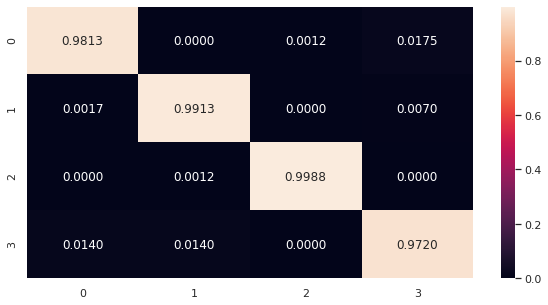

In [12]:
pipeline = Pipeline([
    ('handles', RemoveHandles()),
    ('coded', RemoveCodedValues()),
    ('emoji', TokenizeEmoji()),
    ('emojify', Emojifier()),
    ('counts', CountVectorizer())
])

prepared_train_X = pipeline.fit_transform(train_X)

best_clf, score = test_classifiers(classifiers, prepared_train_X, train_y)

### Final Model Comparison
We have deployed three machine learning models and created the final model structure. Now lets check the accuracy of the models.

|Model|Accuracy Score|
|---|---|
|KNN Classifier|0.39|
|Random Forest Clasifier|0.83|
|Linear SVC|0.83|

Best Classifier Model here, **Random Forest Classifier and Linear SVC**, *with accuracy score of 0.83*.

But here we are going with a single model, based on the baseline score and tokenizer score, **Random Forest Classifier** is the best model in this case and we'll be going with this model.

******************************

Accuracy on validation: 0.8213256484149856


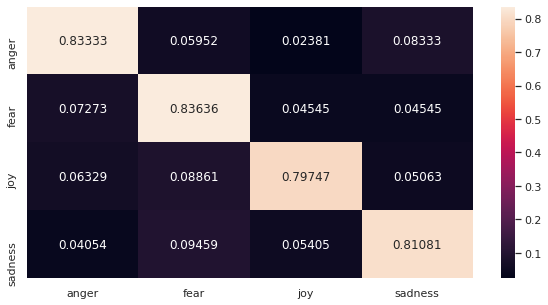

In [13]:
# Try best classifier in the validation dataset
val_X_transformed = pipeline.transform(val_X)
val_y_predicted = best_clf.predict(val_X_transformed)

accuracy = accuracy_score(val_y, val_y_predicted)
print('Accuracy on validation:', accuracy)

conf_matrix = confusion_matrix(val_y, val_y_predicted, normalize='true')
conf_matrix = pd.DataFrame(conf_matrix, columns=best_clf.classes_, index=best_clf.classes_)
# sums = np.sum(conf_matrix, axis=1, keepdims=True)


plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='.5f')
plt.show()

**Observation** : The validation score of this Random Forest Classifier is 0.82

****************************
### Error analysis

Look at the errors that the classifier is doing to get where the problem could be
arising.

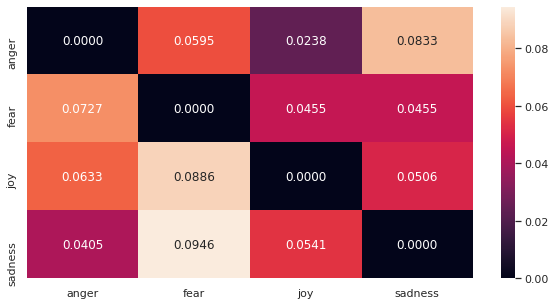

              precision    recall  f1-score   support

       anger       0.81      0.83      0.82        84
        fear       0.83      0.84      0.83       110
         joy       0.85      0.80      0.82        79
     sadness       0.79      0.81      0.80        74

    accuracy                           0.82       347
   macro avg       0.82      0.82      0.82       347
weighted avg       0.82      0.82      0.82       347

['anger' 'fear' 'joy' 'sadness']


In [14]:
# Plot the previous heatmap, but with emphasis in the errors

np.fill_diagonal(conf_matrix.values, 0)

plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='.4f')
plt.show()

print(classification_report(val_y, val_y_predicted))
print(best_clf.classes_)

In [15]:
# Check some examples of errors

errors = val_y != val_y_predicted
errors_to_show = 10

for text, label, predicted in zip(val_X[errors], val_y[errors], val_y_predicted[errors]):
    print('%s -> %s\n\t%s' % (label, predicted, text))

    errors_to_show -= 1
    if errors_to_show == 0:
        break

joy -> fear
	Nawaz Sharif is getting more funnier than @kapilsharmak9 day by day.  #challenge #kashmir #baloch
joy -> anger
	@Casper10666 I assure you there is no laughter, but increasing anger at the costs, and arrogance of Westminster.
joy -> sadness
	Somebody who has braved the storm is brewing. 
joy -> sadness
	Imagine how sad LA fans are gona be when they get eliminated...Man that's gonna be Nirvana, a religious experience rejoicing in their misery
joy -> sadness
	incredible that anthony weiner has been caught chasing a busty milkmaid across a park at double speed while jaunty music plays
joy -> fear
	@len_snart Mick nods. 'I would like that.' He went back to his food, smiling as he finished it.
joy -> fear
	@HunterDean_ [he gives a gleeful squeak and wraps around you] All mine!
joy -> fear
	@hesham786 that's the spirit 
joy -> fear
	@harrietemmett great minds think alike. 
joy -> sadness
	Dolores.' A thin lipped smile graced glossed lips as she let blues peer over at the woman. '

************
### Hyper-parameter tweaking
In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters are learned.

Try to get the most of the classifiers by tweaking hyperparameters.

In [16]:
pipeline = Pipeline([
    ('handles', RemoveHandles()),
    ('coded', RemoveCodedValues()),
    ('emoji', TokenizeEmoji()),
    ('emojify', Emojifier()),
    ('counts', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=random_state))
])

grid_params = [{
    # 'handles': ['passthrough', RemoveHandles()], # Eliminate bias per author or mentioned people
    'coded': ['passthrough', RemoveCodedValues()],
    'emoji': ['passthrough', TokenizeEmoji()],
    'emojify': ['passthrough', Emojifier()],
    # 'clf__n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)],
    # 'clf__max_features': ['auto', 'sqrt'],
    'clf__max_depth': [int(x) for x in np.linspace(10, 100, num=4)] + [None,],
    'clf__bootstrap': [True, False]
}]

grid_search = GridSearchCV(pipeline, grid_params, scoring='accuracy',
                           refit=True, cv=5, n_jobs=16,
                           verbose=2)
grid_search.fit(train_X, train_y)

print(grid_search.best_score_, grid_search.best_estimator_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
0.8449864560943745 Pipeline(steps=[('handles', RemoveHandles()), ('coded', RemoveCodedValues()),
                ('emoji', TokenizeEmoji()), ('emojify', 'passthrough'),
                ('counts', CountVectorizer()),
                ('clf',
                 RandomForestClassifier(bootstrap=False, random_state=143))])


**Observation** : The score of Random Forest Classifier on 5-fold CV is 0.84

******************************************
## Conclusion
1. For creating the baseline model, Linear SVC is showing the accuracy of 0.84. Although the Random Forest classifier was not far behind, it is also having the score of 0.82.
2. For Tokenizer model the Random Forest Classifier is having the accuracy of 0.74, but the Linear SVC is showing a poor accuracy score.
3. Final model was created by Random forest classifier and it provides the accuracy of 0.83.
4. After Hyper-parameter tweaking the Random Forest classifier improves its accuracy and the score is 0.84.
5. The best model for this dataset and for this classification model is **Random Forest Classifier on Grid Search on 5-fold Cross Validation**.

********************************************
### Hope this project will help you. Thank you!